## Defind parameter

In [1]:
input_filepath = 'input'
output_filepath = 'output'
start_date = 2013
end_date = 2019
Sector = 'Automotive'
Sale_group = 151
test_size = 0.2
month_step = 12

## Import library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import itertools

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso, Ridge

import warnings
warnings.filterwarnings('ignore')
from operator import itemgetter
import datetime
from datetime import date

## Defind function

In [3]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    return X_train, X_test, y_train, y_test

def plotCoefficients(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    return coefs

In [4]:
## ฟังก์ชั่นเขียนเองโดย PTT Digital สำหรับพล็อตกราฟ ไม่ใช่ของอาจารย์ KMUTT
def custom_plot_var_forc_from_df(prior, forc, err_upper, err_lower, actual,
                  index=None, names=None, plot_stderr=True, plot_actual=False, legend_options=None, titles=None):

    fig = plt.figure(figsize=(20, 8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = plt.subplot()
    
    lagConnect = []
    lagConnect.append(prior.index[-1])
    lagConnect.extend(list(forc.index))
    
    lagConnect2 = []
    lagConnect2.append(prior.index[-1])
    lagConnect2.extend(list(actual.index))

    ax.plot(prior.index[-36:], prior[names][-36:], 'k', label='Observed', marker='o')
    ax.plot(lagConnect, np.r_[prior[names][-1], forc[names]], 'r--', label='Forecast', marker='+')
    
    if plot_actual:
        ax.plot(lagConnect2, np.r_[prior[names][-1], actual[names]], 'b', marker='o', label='Actual')

    if plot_stderr:
        ax.plot(err_upper.index, err_upper[names], 'lightcoral', ls='-.', label='Forecast STD err (alpha 0.05)', marker='+')
        ax.plot(err_lower.index, err_lower[names], 'lightcoral', ls='-.', marker='+')

    if titles is not None:
        ax.set_title(titles, fontsize=18)

    if legend_options is None:
        legend_options = {"loc": "upper left"}
    ax.legend(**legend_options)
    ax.grid(color='k', linestyle='--', linewidth=0.5)
    plt.xlabel('datetime')
    plt.ylabel('NG Consumption (MMBTU)')
    plt.gca().xaxis.set_major_locator(MaxNLocator(prune='lower'))
    return fig

## Read file

In [84]:
df = pd.read_csv(input_filepath+'/GasConsumption.csv',index_col=0)
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')

## Data preprocess

**Focus on selected group**

In [145]:
data = df[(df.Sector==Sector)&(df.Sales_group_code==Sale_group)]    
data = data.drop(columns=['Sector','Sales_group_code'])

In [146]:
print (data.index.min())
print (data.index.max())

2013-01-01 00:00:00
2019-12-01 00:00:00


In [147]:
data = data.reindex(data.index.union(pd.date_range(start=df.index.max(), freq="M", periods=month_step+1)[1:]))

In [148]:
data[['Number_of_days_ADQ',
       'Quantity_MMC', 'Price_Per_Unit', 'Gas_Value', 'Demand_Charge',
       'Total_Revenue', 'N_Customer', 'LPG_Price_At_Refinery', 'Tax', 'M_Tax',
       'Oil_Fund', 'Wholesale_Price', 'Vat', 'Price_From_Wholesale_Vat',
       'Marketing_Margin', 'Marketing_Margin_Vat', 'Retail_Price',
       'Quantity_Use_NG_GSP', 'Quantity_Use_NG_Industry',
       'Quantity_Use_NG_NGV', 'Quantity_Use_NG_Power',
       'Quantity_Import_NG_LNG', 'Quantity_Import_NG_Myanmar',
       'Quantity_Import_NG_Offshore', 'Quantity_Import_NG_Onshore',
       'Quantity_Import_Other_Country', 'Quantity_Import_Production',
       'Oil_Price_Avg_SFO', 'LNG_Price', 'Exchange_Rate', 'Year', 'Month',
       'GDP', 'Sector_Production', 'Sector_Month_End_Inv', 'Sector_Capacity']] = data[['Number_of_days_ADQ',
       'Quantity_MMC', 'Price_Per_Unit', 'Gas_Value', 'Demand_Charge',
       'Total_Revenue', 'N_Customer', 'LPG_Price_At_Refinery', 'Tax', 'M_Tax',
       'Oil_Fund', 'Wholesale_Price', 'Vat', 'Price_From_Wholesale_Vat',
       'Marketing_Margin', 'Marketing_Margin_Vat', 'Retail_Price',
       'Quantity_Use_NG_GSP', 'Quantity_Use_NG_Industry',
       'Quantity_Use_NG_NGV', 'Quantity_Use_NG_Power',
       'Quantity_Import_NG_LNG', 'Quantity_Import_NG_Myanmar',
       'Quantity_Import_NG_Offshore', 'Quantity_Import_NG_Onshore',
       'Quantity_Import_Other_Country', 'Quantity_Import_Production',
       'Oil_Price_Avg_SFO', 'LNG_Price', 'Exchange_Rate', 'Year', 'Month',
       'GDP', 'Sector_Production', 'Sector_Month_End_Inv', 'Sector_Capacity']].shift(12)
new_data = data[str(data.index.min().year+1):]   # จุดนี้เป็นเทคนิคที่เขาเพิ่มมา
#new_data = data.copy()

**Train/test split**

In [149]:
y = new_data.dropna().Quantity_MMBTU
y_obs = pd.DataFrame(y)
X = new_data.dropna().drop(['Quantity_MMBTU','Quantity_MMC'], axis=1)

scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
X_scaled.index = X.index

# test_size 20% ไม่สุ่ม
X_train = X_scaled[0:57]
y_train = y[0:57]
X_test = X_scaled[57:72]
y_test = y[57:72]

X_Exog = X_scaled[-month_step:]
y_Target = y[-month_step:]

In [150]:
print (f'X_train min = {X_train.index.min()} ; X_train max = {X_train.index.max()}')
print (f'X_test min  = {X_test.index.min()} ; X_test max  = {X_test.index.max()}')
print (f'X_Scale min = {X_scaled.index.min()} ; X_Scale max = {X_scaled.index.max()}')

X_train min = 2014-01-01 00:00:00 ; X_train max = 2018-09-01 00:00:00
X_test min  = 2018-10-01 00:00:00 ; X_test max  = 2019-12-01 00:00:00
X_Scale min = 2014-01-01 00:00:00 ; X_Scale max = 2019-12-01 00:00:00


## Modeling

In [151]:
Feature_importance = pd.DataFrame()
RMSE = pd.DataFrame()

### Ridge regression : find the feature importance

In [152]:
kfcv = KFold(n_splits=5)

In [153]:
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 80, 100, 120,150,180,200,250,300,500,800,4000,4100]}
ridge2 = Ridge()

## [DEPRECATE CODE ON scikit-learn 0.22.2] ##
# finder = GridSearchCV(ridge2,parameters,scoring='mean_squared_error',cv=kfcv)
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

finder = GridSearchCV(ridge2,parameters,scoring='neg_mean_squared_error',cv=kfcv)
finder.fit(X_train,y_train)
ridge2 = finder.best_estimator_

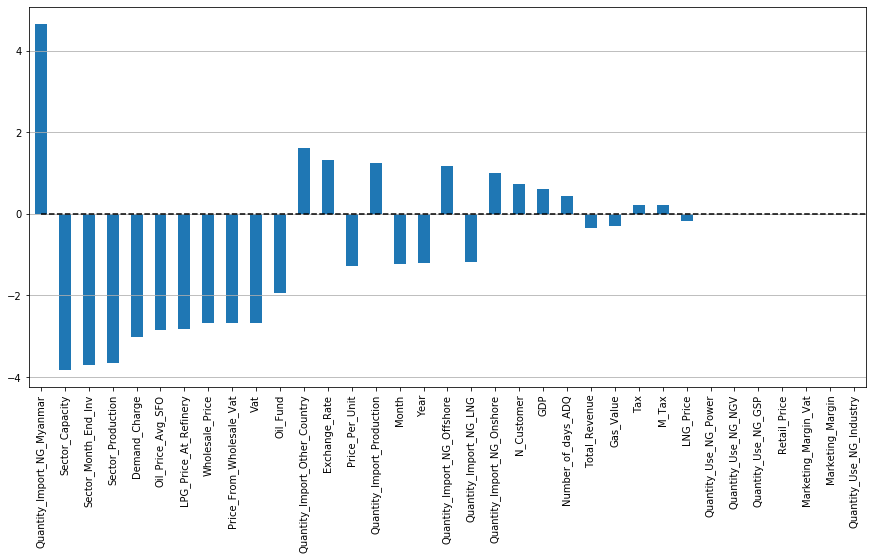

In [154]:
result = plotCoefficients(ridge2)

In [155]:
Feature_importance['Ridge'] = result.index[:5]

### Sarimax with Ridge's factor

In [156]:
# Factor จากการทดสอบของอาจารย์
#factor = ['Quantity_Use_NG_Power','Quantity_Use_NG_NGV','Quantity_Use_NG_GSP','Quantity_Import_NG_Myanmar','Demand_Charge']
# Factor ที่หาได้จากโมเดล อาจขึ้นกับ Machine ที่รันโมเดลด้วย
factor = Feature_importance.Ridge.values.tolist()

In [157]:
max_pq = 3
p = d = q = list(range(0, int(max_pq)))
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [158]:
# https://otexts.com/fpp2/seasonal-arima.html
# Endogenous คล้ายกับ Dependent Var (Y)
# Exogenous คล้ายกับ Independent Var (X)
# p = Auto Regressive parameters
# d = differences, integration order of the process
# q = Moving Average parameters
# m = number of observations per year
# (p,d,q) = Non-seasonal part of model
# (p,d,q,m) หรือ seasonal_pdq = Seasonal part of model

In [159]:
best_mod = []
# วนลูปหาผลลัพธ์โมเดลตาม pdq
for param in pdq:
    # วนลูปหาผลลัพธ์โมเดลตาม seasonal pdq
    for param_seasonal in seasonal_pdq:
        try:
            # y_train,X_train[factor] ข้อมูล standardized ตั้งแต่ 2014-2018
            mod = sm.tsa.statespace.SARIMAX(y_train, order=param, seasonal_order=param_seasonal,
                                            exog=X_train[factor], enforce_stationarity=False,
                                            enforce_invertibility=False)
            result = mod.fit()
            # X_test[factor] ข้อมูล standardized เฉพาะปี 2019 (Out-of-sample prediction)
            predict = result.forecast(steps=X_test.shape[0], exog=X_test[factor])
            error = np.sqrt(mean_squared_error(y_test, predict))
            best_mod.append((result,(param,param_seasonal),error,predict))
        except Exception as e:
            continue
# จัดเรียงผลดีที่สุด ตามค่า MSE จากน้อยไปหามาก
best_mod.sort(key=itemgetter(2))  

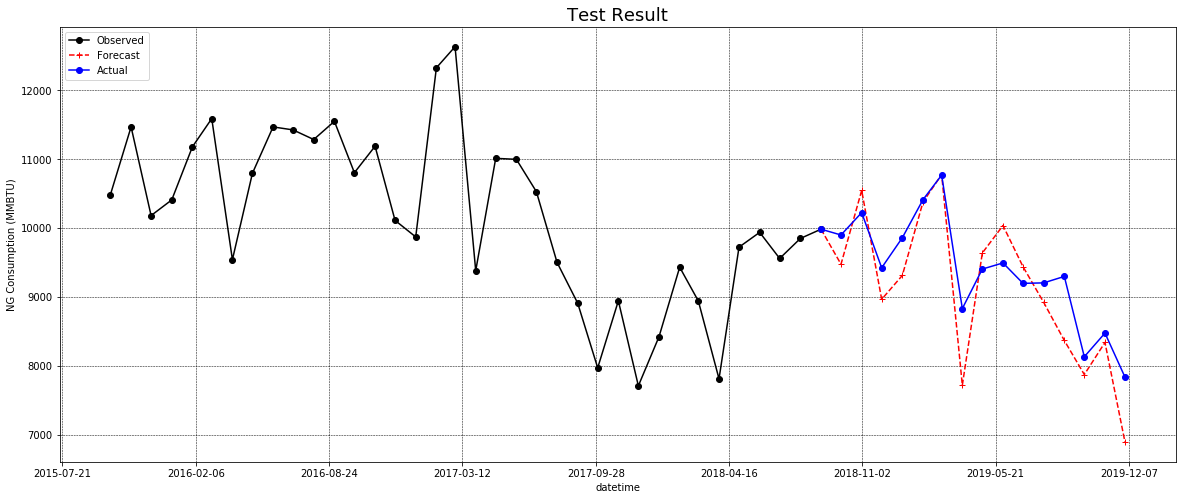

In [160]:
## Visual Plot : by PTT Digital
best_train_plot = pd.DataFrame(best_mod[0][3],columns=['Quantity_MMBTU'])
yTrain_plot = pd.DataFrame(y_train,columns=['Quantity_MMBTU'])
yTest_plot = pd.DataFrame(y_test,columns=['Quantity_MMBTU'])
fig = custom_plot_var_forc_from_df(yTrain_plot, best_train_plot, None, None, yTest_plot, 
                                   names='Quantity_MMBTU', plot_stderr=False, plot_actual=True,titles='Test Result')

In [161]:
RMSE['Sarimax_Ridge'] = [best_mod[0][2]]
print('Sarimax with Ridge best Model: RMSE:',best_mod[0][2],' Parameter:',best_mod[0][1])

Sarimax with Ridge best Model: RMSE: 538.9660748891321  Parameter: ((0, 1, 0), (2, 1, 1, 12))


Save Sarimax with Ridge output

In [ ]:
#out_error = pd.DataFrame([best_mod[0][2]],columns=['RMSE'])
#out_error.to_csv(output_filepath+'/GasConsumption_Sarimax_Ridge_evaluation_.csv')

In [ ]:
#out = pd.DataFrame(best_mod[0][3],columns=['predict'])
#out['actual'] = y_test.values
#out = out[['actual','predict']]
#out = out.reset_index().rename(columns={'index': 'date'})
#out.to_csv(output_filepath+'/GasConsumption_Sarimax_Ridge_prediction.csv')

### RMSE of all algorithm

In [ ]:
#RMSE

### Factor in each algorithm

In [162]:
Feature_importance

,Ridge
0,Quantity_Import_NG_Myanmar
1,Sector_Capacity
2,Sector_Month_End_Inv
3,Sector_Production
4,Demand_Charge


### Future projection predict with best mod SARIMAX hyperparameter

In [163]:
best_param = best_mod[0][1][0]
best_param_seasonal = best_mod[0][1][1]
#best_param = (0, 1, 0)
#best_param_seasonal = (2, 1, 1, 12)
    
try:
    #X_scaled[factor] ข้อมูล standardized ตั้งแต่ 2014-2018
    model = sm.tsa.statespace.SARIMAX(y_obs, order=best_param, seasonal_order=best_param_seasonal,
                                    exog=X_scaled[factor], enforce_stationarity=False,
                                    enforce_invertibility=False)
    
    model_result = model.fit()
    # exog ข้อมูล standardized (Out-of-sample prediction) เพื่อทำนาย 2019-2020
    # model_result.forecast ค่า step จะเป็นช่วงเวลาหลัง train
    model_predict = model_result.forecast(steps=month_step, exog=X_Exog[factor])
except Exception as e:
    print('Error :',e)

In [164]:
forc_out_plot = pd.DataFrame(model_predict,columns=['Quantity_MMBTU'])
forc_out = pd.DataFrame(model_predict,columns=['predict'])
forc_out['actual'] = None
forc_out_Tofile = forc_out[['actual','predict']]
forc_out_Tofile = forc_out_Tofile.reset_index().rename(columns={'index': 'date'})
forc_out_Tofile.to_csv(output_filepath+'/GasConsumption_Sarimax_Ridge_12months_forecast.csv',index=False)

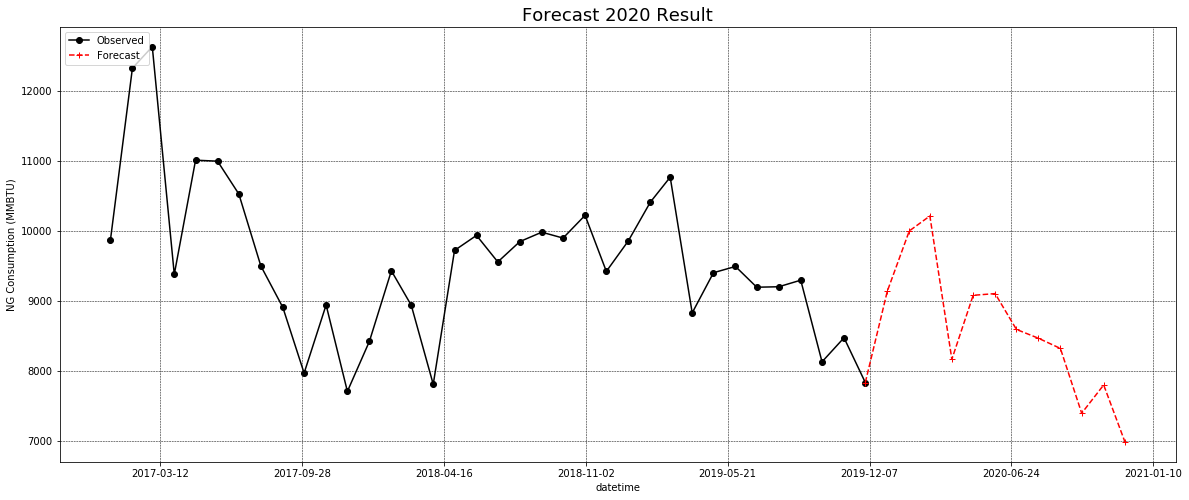

In [165]:
fig = custom_plot_var_forc_from_df(y_obs, forc_out_plot, None, None,
                                   pd.DataFrame(), names='Quantity_MMBTU', plot_stderr=False, 
                                   plot_actual=False, titles='Forecast 2020 Result')